In [2]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import cv2

In [5]:
# Config
image_length = 100;
image_width = 100;
number_of_channels = 1;
num = 4

In [6]:
size = 100
max_obj_num = 6

In [15]:
#image = np.zeros(shape=(image_length, image_width, 1),dtype =np.uint8)


In [16]:
    thickness = np.random.randint(1, 3)  # line thickness.   (random)

    image = np.ones(shape=(size, size, 1))
    subImages = [np.ones(shape=(size,size,1)) for i in range(max_obj_num)]
    heights = np.random.randint(10,80,size=(num))

    barWidth = int( (size-3*(num+1)-3)//num * (np.random.randint(50,100)/100.0) )
    barWidth = max(barWidth, 4)
    spaceWidth = (size-(barWidth)*num)//(num+1)

    sx = (size - barWidth*num - spaceWidth*(num-1))//2
    for i in range(num):

        sy = size - 1
        ex = sx + barWidth
        ey = sy - heights[i]

        cv2.rectangle(image,(sx,sy),(ex,ey),0,thickness)
        cv2.rectangle(subImages[i],(sx,sy),(ex,ey),0,thickness)
        sx = ex + spaceWidth

In [19]:
cv2.imshow('this',image*255)

In [9]:
cv2.imwrite('./test.jpg', image * 255)


True

In [14]:
barWidth = int( (100-3*(5+1)-3)//5 * (np.random.randint(50,100)/100.0) )


In [16]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'np.random.randint(10,80,size=(1))',
  'import numpy as np\nfrom numpy import random\nimport matplotlib.pyplot as plt\nimport cv2',
  'np.random.randint(10,80,size=(1))',
  'np.random.randint(10,80,size=(2))',
  'np.random.randint(10,80,size=(100))',
  'number_of_bars = np.random.randint(2, config.max_obj_num + 1)\nthickness = np.random.randint(1, config.max_thickness)\nheight = np.random.randint(10, config.image_height - 20, size = number_of_bars)',
  'barWidth = int( (size-3*(num+1)-3)//num * (np.random.randint(50,100)/100.0) )',
  'barWidth = int( (100-3*(5+1)-3)//5 * (np.random.randint(50,100)/100.0) )',
  'barWidth',
  'barWidth = int( (100-3*(5+1)-3)//5 * (np.random.randint(50,100)/100.0) )',
  'barWidth',

In [15]:
    r = np.random.randint(25,45)        # Radii of the pie. (random)

    colors = np.random.uniform(0.0, 0.9,size = (6,3))
    center = (int(size/2),int(size/2))  #
    image = np.ones(shape=(size, size, 3))
    subImages = [np.ones(shape=(size,size,3)) for i in range(6)]
    angles = Normalize(np.random.randint(10,60,size=(num)))

    start_angle = 90 - np.random.randint(0,360*angles[0])/2.0
    _cur_start_angle = start_angle
    # cv2.circle(image,center,r,0,thickness)

    for i in range(num):
        _cur_end_angle = _cur_start_angle + angles[i] * 360.0

        cv2.ellipse(image, center, (r, r), 270, -_cur_start_angle, -_cur_end_angle, colors[i], -1)
        cv2.ellipse(subImages[i],center,(r,r),270,-_cur_start_angle,-_cur_end_angle,colors[i], -1)
        _cur_start_angle = _cur_end_angle


In [19]:
ls


README.md                      build_model.py
Testing_showing_results.ipynb  config.py
__pycache__/                   image_generator.py


In [26]:
import os
import pandas as pd

filenames = os.listdir("../Data/")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'Bar':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [27]:
df

,filename,category
0,Pie_image87.jpg,0
1,Pie_image93.jpg,0
2,Pie_image78.jpg,0
3,Pie_image44.jpg,0
4,Pie_image50.jpg,0
...,...,...
195,Bar_image63.jpg,1
196,Bar_image77.jpg,1
197,Pie_image49.jpg,0
198,Pie_image75.jpg,0


<AxesSubplot: >

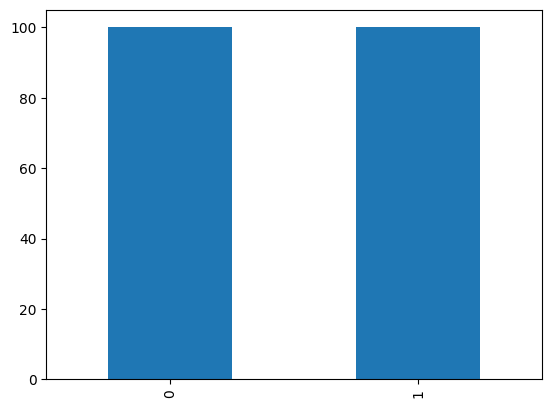

In [28]:
df['category'].value_counts().plot.bar()
